# Прогнозирование временных рядов на карте

Скачайте сырые данные о поездках жёлтого такси с сайта TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

Поездки зелёного такси и лимузинов нас не интересуют!

Данные выложены в файлах по месяцам. Скачайте так много данных жёлтого такси, как сможете; чем больше вы будете использовать данных, тем точнее получатся ваши прогнозы. Если вы решите использовать не все данные, а только часть, выбирайте её по времени с конца. Абсолютный минимум необходимых данных — 6 месяцев: один, последний месяц, вам понадобится для тестирования, предшествующие 5 — для обучения. По 5 месяцам можно построить прогнозы, учитывающие дневную и недельную сезонности, но в данных есть и годовая. Чтобы её учесть, необходимы данные как минимум за 2 года. 

Обработайте сырые данные по следующей схеме.

1. Почистите данные от ошибок и аномалий.
2. Отбросьте минуты и секунды во времени начала поездки.
3. Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. Разбейте этот прямоугольник на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси.
4. Посчитайте количество поездок за каждый час из каждой области. Не забудьте, что если в сырых данных для какой-то пары час-область нет ни одной записи, то в агрегированных данных для неё должен стоять 0.

В дальнейшем, когда вы будете предсказывать получившиеся ряды, нужно будет загружать ваши прогнозы на kaggle, поэтому нужно, чтобы идентификаторы ячеек были определены однозначно. В следующем файле даны идентификаторы ячеек, которые вам нужно использовать, и географические координаты их границ: 



# Описание данных


1. **VendorID** - Код поставщика

(1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)

2. **tpep_pickup_datetime** - Время, когда таксометр был включен  

3. **tpep_dropoff_datetime** - Время, когда таксометр был отключен 

4. **Passenger_count** Количество пассажиров в поездке

5. **Trip_distance** Прошедшее расстояние в милях, указанное в таксометре

6. **PULocationID** Координаты, где был включен таксометр

7. **DOLocationID** Координаты, где был отключен таксометр

8. **RateCodeID** Последний код тарифа

1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride

9. **Store_and_fwd_flag** Этот флаг указывает, хранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику, иначе говоря, «сохранить и пересылать», поскольку у транспортного средства не было соединения с сервером.

Y= store and forward trip
N= not a store and forward trip

10. **Payment_type** Как клиент оплатил такси

1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip

11. **Fare_amount** Стоимость поездки рассчитанная по таксометру

12. **Extra** Разные дополнения и доплаты. В настоящее время это включает только 0,50 доллара США и 1 доллар США в час пик и оплату за ночь.

13. **MTA_tax** Налог MTA в размере 0,50 доллара США, который автоматически взимается в зависимости от используемой измеренной ставки.

14. **Improvement_surcharge** Доплата за улучшение в размере 0,30 доллара за поездки при спуске флага. Надбавка за благоустройство начала взиматься в 2015 году.

15. **Tip_amount** Сумма чаевых - это поле автоматически заполняется для чаевых по кредитной карте. Денежные чаевые не включены.

16. **Tolls_amount** Общая сумма всех оплаченных дорожных сборов за поездку.

17. **Total_amount** Общая сумма взимается с пассажиров. Не включает денежные чаевые.



# Задания

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/final_project/')

%cd "/final_project/MyDrive/final_project"
%ls

Drive already mounted at /final_project/; to attempt to forcibly remount, call drive.mount("/final_project/", force_remount=True).
/final_project/MyDrive/final_project
 regions.csv   yellow_tripdata_2016-05.csv  'Копия блокнота "Project.ipynb"'


Для сдачи задания этой недели вам нужно агрегировать только данные за май 2016, но, когда задание будет сдано, не забудьте запустить ваш агрегирующий скрипт на всех остальных месяцах, которые вы собираетесь использовать при прогнозировании.

Чтобы сдать задание, выполните следующую последовательность действий.

### 1. Загрузите данные за май 2016 года.

In [2]:
data = pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
regions = pd.read_csv('regions.csv', sep=';')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


### 2. Проведите фильтрацию: удалите поездки с

- нулевой длительностью

- нулевым количеством пассажиров

- нулевым расстоянием поездки по счётчику

- координатами начала, не попадающими в прямоугольник Нью-Йорка

Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково. 

In [3]:
# удаляем поездки с нулевой длительностью
data['trip_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

In [4]:
# удаляем поездки с нулевым количеством пассажиров
data = data[data.passenger_count != 0]

In [5]:
# удаляем поездки с нулевым расстояние поездки
data = data[data.trip_distance != 0]

In [6]:
# удаляем поездки с координатами не в Нью-Йорке
NY_location = ((data.pickup_longitude > -74.25559) & (data.pickup_longitude < -73.70001)) & ((data.pickup_latitude > 40.49612) & (data.pickup_latitude < 40.91553))
data = data[NY_location]

### 3. Агрегируйте данные за май 2016 года по часам и областям 
(можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.



In [7]:
# добавляем столбец с часом
data['tpep_pickup_hour'] = data.tpep_pickup_datetime.map(lambda x: x.floor(freq='h'))


# определяем номер региона для каждого вызова такси (скопировал из обсуждений)
statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                data['pickup_latitude'].values, 
                                data['VendorID'], 
                                statistic='count', 
                                bins=[regions['west'].append(regions['east']).unique(), 
                                      regions['south'].append(regions['north']).unique()], 
                                expand_binnumbers=True)
                                  
data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

In [8]:
agg_table = pd.pivot_table(data, values='VendorID', columns='tpep_pickup_hour', index='region', aggfunc='count')

### 4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.



In [9]:
agg_table.head()

tpep_pickup_hour,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,2016-05-01 09:00:00,2016-05-01 10:00:00,2016-05-01 11:00:00,2016-05-01 12:00:00,2016-05-01 13:00:00,2016-05-01 14:00:00,2016-05-01 15:00:00,2016-05-01 16:00:00,2016-05-01 17:00:00,2016-05-01 18:00:00,2016-05-01 19:00:00,2016-05-01 20:00:00,2016-05-01 21:00:00,2016-05-01 22:00:00,2016-05-01 23:00:00,2016-05-02 00:00:00,2016-05-02 01:00:00,2016-05-02 02:00:00,2016-05-02 03:00:00,2016-05-02 04:00:00,2016-05-02 05:00:00,2016-05-02 06:00:00,2016-05-02 07:00:00,2016-05-02 08:00:00,2016-05-02 09:00:00,2016-05-02 10:00:00,2016-05-02 11:00:00,2016-05-02 12:00:00,2016-05-02 13:00:00,2016-05-02 14:00:00,2016-05-02 15:00:00,...,2016-05-30 08:00:00,2016-05-30 09:00:00,2016-05-30 10:00:00,2016-05-30 11:00:00,2016-05-30 12:00:00,2016-05-30 13:00:00,2016-05-30 14:00:00,2016-05-30 15:00:00,2016-05-30 16:00:00,2016-05-30 17:00:00,2016-05-30 18:00:00,2016-05-30 19:00:00,2016-05-30 20:00:00,2016-05-30 21:00:00,2016-05-30 22:00:00,2016-05-30 23:00:00,2016-05-31 00:00:00,2016-05-31 01:00:00,2016-05-31 02:00:00,2016-05-31 03:00:00,2016-05-31 04:00:00,2016-05-31 05:00:00,2016-05-31 06:00:00,2016-05-31 07:00:00,2016-05-31 08:00:00,2016-05-31 09:00:00,2016-05-31 10:00:00,2016-05-31 11:00:00,2016-05-31 12:00:00,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.



Гугл гласит:
The latitude of Empire State Building, New York, USA is 40.748817, and the longitude is -73.985428

In [10]:
# отфильтровываем таблицу регионов координатами из гугла и выбираем самую последнюю строку
ESB_region = regions[(regions['south'] < 40.748817) & (regions['west'] < -73.985428)].iloc[-1]
ESB_region

region    1231.000000
west       -73.988912
east       -73.977800
south       40.747766
north       40.756154
Name: 1230, dtype: float64

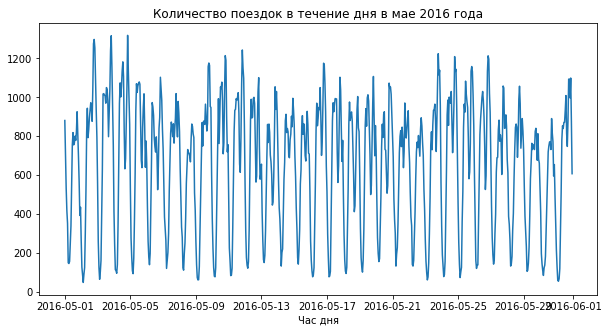

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(agg_table.loc[ESB_region.region])
plt.title('Количество поездок в течение дня в мае 2016 года')
plt.xlabel('Час дня')
plt.show()

### 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.



In [12]:
print('Всего пар час-область', len(regions) * 24 * 31)
print('Всего областей в которых была хоть 1 поездка (из 2500): ', len(agg_table))

# складываем количество пар для 1283 областей, которые отсутствуют в выборке
# и количество пустых клеток в агрегированной таблице
print('Всего пар час-область в которых не было совершено ни одной поездки', ((len(regions) - len(agg_table)) * 24 * 31) + agg_table.isnull().sum().sum())

Всего пар час-область 1860000
Всего областей в которых была хоть 1 поездка (из 2500):  1217
Всего пар час-область в которых не было совершено ни одной поездки 1718238
